In [26]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [27]:
import os
import pathlib
import pandas as pd
import numpy as np
import PIL
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl

%matplotlib inline

### Load the image data

In [1]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('muratkokludataset/rice-image-dataset', path='.', unzip=True)


In [3]:
seed = 123

In [4]:
# Split dataset into three folds
import splitfolders 
splitfolders.ratio("Rice_Image_Dataset", output="dataset",
    seed=seed, ratio=(.8, .1, .1), group_prefix=None, move=True)


Copying files: 75000 files [00:02, 33938.54 files/s]


In [37]:
# Check the image size of all images to make sure they are uniform
from glob import glob
image_files = glob('dataset/train/**/*.jpg', recursive=True)
sizes = {}
for image in image_files:
    handle = PIL.Image.open(image)
    if handle.size not in sizes:
        sizes[handle.size] = 0
    sizes[handle.size] += 1

print(sizes)

{(250, 250): 60000}


In [38]:
batch_size = 64
img_height = 250
img_width = 250

In [39]:
# Create train/test/validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
  'dataset/train',
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  'dataset/test',
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'dataset/val',
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 60000 files belonging to 5 classes.
Found 7500 files belonging to 5 classes.
Found 7500 files belonging to 5 classes.


In [40]:
class_names = train_ds.class_names
print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


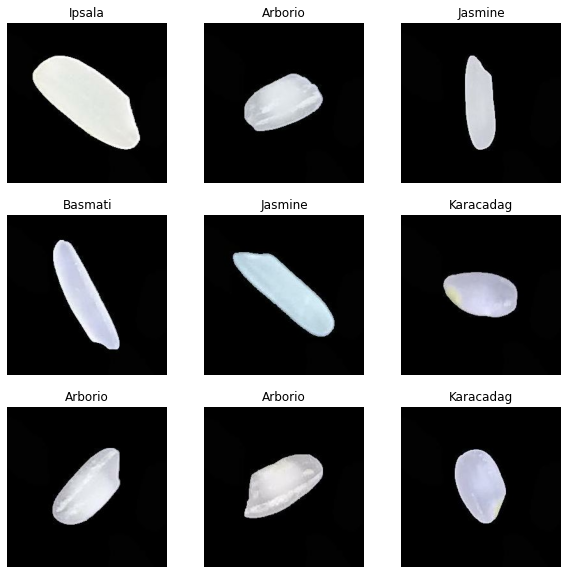

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Preprocess the data

In [42]:
preprocessed_layer = tf.keras.layers.Rescaling(1./255)

In [43]:
preprocessed_ds = train_ds.map(lambda x, y: (preprocessed_layer(x), y))
image_batch, labels_batch = next(iter(preprocessed_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


### Configure the dataset for performance

In [44]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

### Train the model

##### Convolutional neural network model by using function API

In [48]:
# Train the model with a small CNN using function API
num_classes = len(class_names)

def convolutional_model(input_shape):

    img_input = tf.keras.Input(shape=(input_shape))

    Z1 = tfl.Conv2D(32,(4,4),strides=1,padding='same')(img_input)
    A1 = tfl.ReLU()(Z1)
    P1 = tfl.MaxPool2D(pool_size=(8,8),strides=8,padding='same')(A1)
    Z2 = tfl.Conv2D(16,(2,2),strides=1,padding='same')(P1)
    A2 = tfl.ReLU()(Z2)
    P2 = tfl.MaxPool2D(pool_size=(4,4),strides=4,padding='same')(A2)
    F = tfl.Flatten()(P2)
    outputs = tfl.Dense(num_classes, activation='softmax')(F)

    model = tf.keras.Model(inputs=img_input, outputs=outputs)
    return model

conv_model = convolutional_model((250, 250, 3))

conv_model.compile(optimizer = 'adam',
                   loss = tf.losses.SparseCategoricalCrossentropy(),
                   metrics = ['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                            patience = 3,
                                            restore_best_weights = True )                  

conv_model.summary()

history = conv_model.fit(train_ds, epochs = 10, validation_data=val_ds, callbacks=[callback])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 250, 250, 32)      1568      
                                                                 
 re_lu_4 (ReLU)              (None, 250, 250, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        2064      
                                                                 
 re_lu_5 (ReLU)              (None, 32, 32, 16)        0         
                                                           

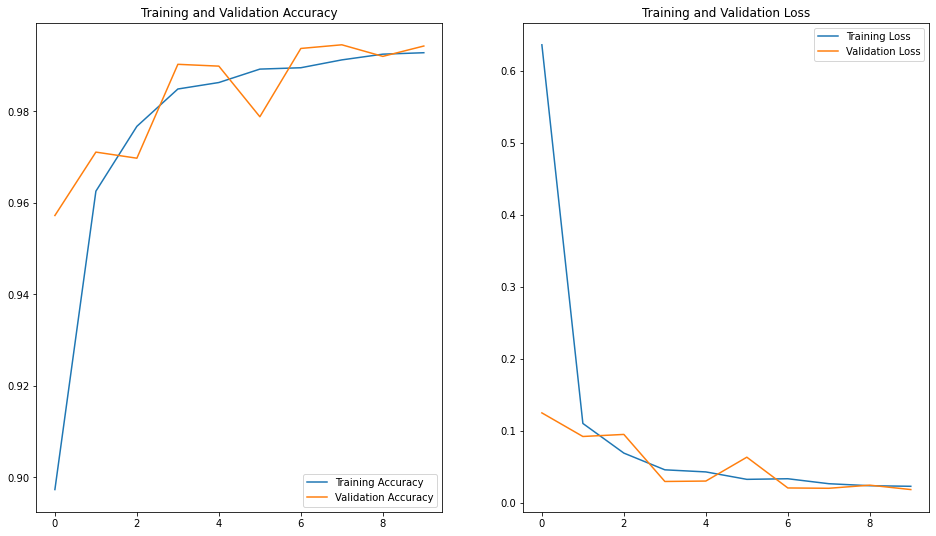

In [49]:
# Visualize the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
# Check the accuracy of the test dataset
loss, accuracy = conv_model.evaluate(test_ds)
print('Test accuracy of the first CNN :', accuracy)

118/118 [==============================] - 3s 24ms/step - loss: 0.0210 - accuracy: 0.9928
Test accuracy of the first CNN : 0.9927999973297119


In [51]:
# Train the model again with dropout
num_classes = len(class_names)

def convolutional_model(input_shape):

    img_input = tf.keras.Input(shape=(input_shape))

    Z1 = tfl.Conv2D(32,(4,4),strides=1,padding='same')(img_input)
    A1 = tfl.ReLU()(Z1)
    P1 = tfl.MaxPool2D(pool_size=(8,8),strides=8,padding='same')(A1)
    Z2 = tfl.Conv2D(16,(2,2),strides=1,padding='same')(P1)
    A2 = tfl.ReLU()(Z2)
    P2 = tfl.MaxPool2D(pool_size=(4,4),strides=4,padding='same')(A2)
    D = tfl.Dropout(0.2)(P2)
    F = tfl.Flatten()(D)
    outputs = tfl.Dense(num_classes, activation='softmax')(F)

    model = tf.keras.Model(inputs=img_input, outputs=outputs)
    return model

conv_model = convolutional_model((250, 250, 3))

conv_model.compile(optimizer = 'adam',
                   loss = tf.losses.SparseCategoricalCrossentropy(),
                   metrics = ['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                            patience = 3,
                                            restore_best_weights = True )                  

conv_model.summary()

history = conv_model.fit(train_ds, epochs = 10, validation_data=val_ds, callbacks=[callback])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 250, 250, 32)      1568      
                                                                 
 re_lu_6 (ReLU)              (None, 250, 250, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 16)        2064      
                                                                 
 re_lu_7 (ReLU)              (None, 32, 32, 16)        0         
                                                           

In [52]:
# Check the accuracy of the test dataset
loss, accuracy = conv_model.evaluate(test_ds)
print('Test accuracy of the first CNN with dropout :', accuracy)

118/118 [==============================] - 3s 24ms/step - loss: 0.0233 - accuracy: 0.9927
Test accuracy of the first CNN with dropout : 0.9926666617393494


In [ ]:
# The accuracy and val_accuracy are almost the same as the previous model without dropput layer, both of them have achived quite good result.

In [53]:
# Save the trained weights
conv_model.save('train_conv_model')

INFO:tensorflow:Assets written to: train_conv_model/assets


INFO:tensorflow:Assets written to: train_conv_model/assets


#### Mobilenetv2 model


In [54]:
# Create the model with Mobilenetv2 and freeze the top layers to train
mobilenet = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling='avg')

for layer in mobilenet.layers:
    layer.trainable = False

mobilenet = tf.keras.Sequential([mobilenet,
                              tfl.Flatten(),
                              tfl.Dropout(0.3),
                              tfl.Dense(num_classes, activation='softmax')])

mobilenet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
               loss = tf.losses.SparseCategoricalCrossentropy(),
               metrics = ['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                            patience = 3,
                                            restore_best_weights = True)                  

mobilenet.summary()

history = mobilenet.fit(train_ds, epochs = 10, validation_data=val_ds, callbacks=[callback])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 1280)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10
938/938 [==============================] - 64s 66ms/step - loss: 0.2462 - accuracy: 0.9095 - val_

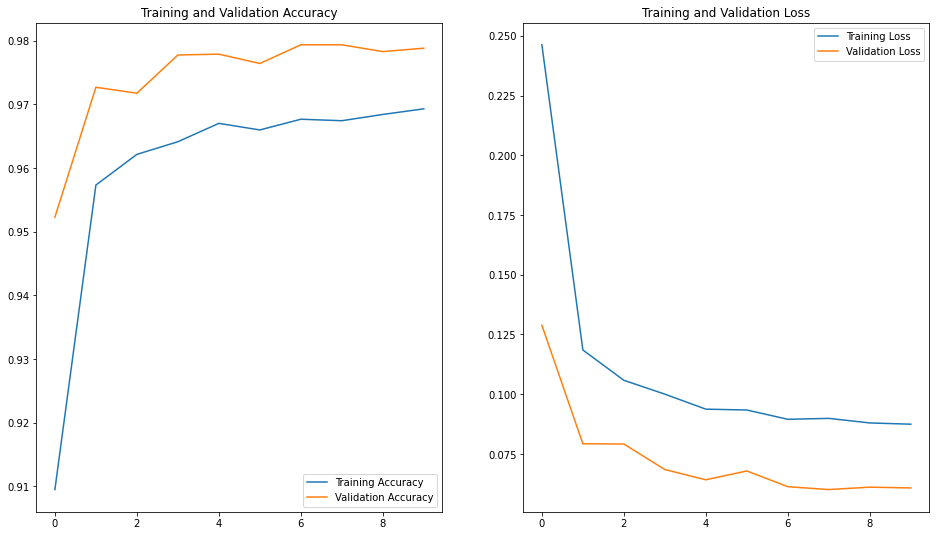

In [55]:
# Visualize the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [56]:
# Check the accuracy of the test dataset
loss, accuracy = conv_model.evaluate(test_ds)
print('Test accuracy of the MobileNetv2 :', accuracy)

118/118 [==============================] - 3s 24ms/step - loss: 0.0233 - accuracy: 0.9927
Test accuracy of the MobileNetv2 : 0.9926666617393494


### Predictions

Predictions and labels:
 [(0, 0), (2, 2), (4, 4), (4, 4), (0, 0), (1, 1), (0, 0), (1, 1), (3, 3), (2, 2), (4, 4), (4, 4), (4, 4), (1, 1), (4, 4), (1, 1), (3, 3), (3, 3), (2, 2), (2, 2), (1, 1), (1, 1), (4, 4), (0, 4), (3, 3), (4, 4), (4, 4), (1, 1), (2, 2), (0, 0), (0, 0), (1, 1), (4, 4), (0, 0), (4, 4), (0, 0), (4, 4), (2, 2), (0, 0), (4, 4), (1, 1), (0, 0), (4, 4), (3, 3), (3, 3), (1, 1), (1, 1), (3, 3), (0, 0), (2, 2), (4, 4), (0, 0), (0, 0), (3, 1), (2, 2), (3, 3), (4, 4), (0, 0), (1, 1), (2, 2), (3, 3), (3, 3), (2, 2), (1, 1)]


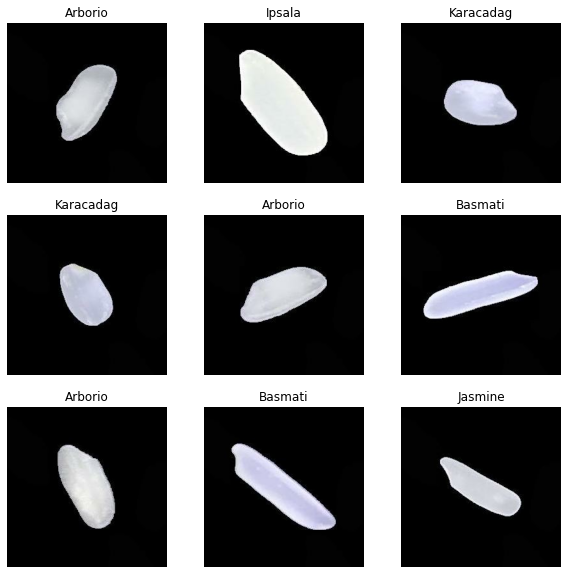

In [75]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = conv_model.predict_on_batch(image_batch)
predictions = [tf.math.argmax(pred).numpy() for pred in predictions]

print('Predictions and labels:\n', list(zip(predictions, label_batch)))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [84]:
# Test with a new image downloaded from internet to see which type of rice it is or not
img = tf.keras.preprocessing.image.load_img('prediction_sample_rice.jpg', target_size=(250, 250))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
prediction = conv_model.predict(img_batch)
print(prediction)
print(tf.math.argmax(prediction).numpy())

1/1 [==============================] - 0s 10ms/step
[[9.4292819e-01 8.0747734e-05 2.2613651e-06 5.6977861e-02 1.1020283e-05]]
[0 0 0 0 0]
